In [1]:
import pandas as pd
from io import StringIO, BytesIO
from scipy.io.arff import loadarff
import urllib.request
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import preprocessing, metrics
from sklearn.model_selection import RepeatedKFold, RepeatedStratifiedKFold, LeaveOneOut
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.linear_model import LinearRegression, BayesianRidge, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn import svm
import matplotlib.pyplot as plt
np.seterr(invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [115]:
cocomo81_url = 'http://promise.site.uottawa.ca/SERepository/datasets/cocomo81.arff'
resp81 = urllib.request.urlopen(cocomo81_url)
cocomo81_data, cocomo81_meta = loadarff(StringIO(resp81.read().decode('utf-8')))
cocomo81_df = pd.DataFrame(cocomo81_data)
cocomo81_df.head()

,rely,data,cplx,time,stor,virt,turn,acap,aexp,pcap,vexp,lexp,modp,tool,sced,loc,actual
0,0.88,1.16,0.70,1.0,1.06,1.15,1.07,1.19,1.13,1.17,1.1,1.00,1.24,1.10,1.04,113.0,2040.0
1,0.88,1.16,0.85,1.0,1.06,1.00,1.07,1.00,0.91,1.00,0.9,0.95,1.10,1.00,1.00,293.0,1600.0
2,1.00,1.16,0.85,1.0,1.00,0.87,0.94,0.86,0.82,0.86,0.9,0.95,0.91,0.91,1.00,132.0,243.0
3,0.75,1.16,0.70,1.0,1.00,0.87,1.00,1.19,0.91,1.42,1.0,0.95,1.24,1.00,1.04,60.0,240.0
4,0.88,0.94,1.00,1.0,1.00,0.87,1.00,1.00,1.00,0.86,0.9,0.95,1.24,1.00,1.00,16.0,33.0


In [3]:
cocomo81_X = cocomo81_df.iloc[:, :-1]
cocomo81_y = cocomo81_df.iloc[:, -1]

In [83]:
def evaluate_model(actual, predicted):
    diff=np.absolute(actual-predicted)
    MRE=diff/actual
    pred = {}
    for x in np.array([.25, .3, .5]):
        P=MRE[MRE<x]
        pred[x] = (P.size/MRE.size) * 100
    return np.mean(MRE), np.median(MRE), pred

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    cocomo81_X, cocomo81_y, test_size=0.25, random_state=42)
X_test.shape

(16, 16)

In [14]:
scorers = {'pred': make_scorer(custom_loss_pred, greater_is_better=True), 'mmre': make_scorer(custom_loss_mmre, greater_is_better=True)}

# Comparison between regression algorithms
## Random Forest Regressor

In [37]:
random_grid={'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': [1,2,3,4,5,6,7,8,9,10],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

In [84]:
clf= RandomForestRegressor()
random_grd_search=RandomizedSearchCV(estimator = clf, param_distributions = random_grid, n_iter = 100, cv = 10, random_state=42, n_jobs = -1)
random_grd_search.fit(X_train, y_train)

RandomizedSearchCV(cv=10, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, None],
                                        'max_features': [1, 2, 3, 4, 5, 6, 7, 8,
                                                         9, 10],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42)

In [85]:
print(random_grd_search.best_score_)
print(random_grd_search.best_params_)
y_predict = random_grd_search.best_estimator_.predict(X_test)
print(evaluate_model(y_test, y_predict))

-4.655847806888499
{'n_estimators': 800, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 10, 'max_depth': 20, 'bootstrap': False}
(1.9750227995986425, 1.3135616776315793, {0.25: 6.25, 0.3: 12.5, 0.5: 18.75})


## SVR

In [86]:
svr_params = {'kernel': ('linear','rbf','poly'), 'C':[1.5, 10],'gamma': [1e-7, 1e-4],'epsilon':[0.1,0.2,0.5,0.3]}

In [87]:
svr= svm.SVR()
svr_random_grd_search=RandomizedSearchCV(estimator = svr, param_distributions = svr_params, n_iter=48, cv = 10, random_state=42, n_jobs = -1)
svr_random_grd_search.fit(X_train, y_train)

RandomizedSearchCV(cv=10, estimator=SVR(), n_iter=48, n_jobs=-1,
                   param_distributions={'C': [1.5, 10],
                                        'epsilon': [0.1, 0.2, 0.5, 0.3],
                                        'gamma': [1e-07, 0.0001],
                                        'kernel': ('linear', 'rbf', 'poly')},
                   random_state=42)

In [88]:
print(svr_random_grd_search.best_params_)
svr_y_predict = svr_random_grd_search.best_estimator_.predict(X_test)
print(evaluate_model(y_test, svr_y_predict))
print(svr_random_grd_search.best_score_)

{'kernel': 'linear', 'gamma': 1e-07, 'epsilon': 0.5, 'C': 10}
(1.2224320421097654, 0.6566375398144461, {0.25: 25.0, 0.3: 31.25, 0.5: 43.75})
-0.02087098609338083


## Decision Tree Regressor

In [89]:
dtr_params={"splitter":["best","random"],
            "max_depth" : [1,3,5,7,9,11,12],
            "min_samples_leaf":[1,2,3,4,5,6,7,8,9,10],
            "min_weight_fraction_leaf":[0.1,0.2,0.3,0.4,0.5],
            "max_features":["auto","log2","sqrt",None],
            "max_leaf_nodes":[None,10,20,30,40,50,60,70,80,90] }

In [90]:
dtr = DecisionTreeRegressor()
dtr_random_grd_search=RandomizedSearchCV(estimator = dtr, param_distributions = dtr_params, n_iter=28000, cv = 10, 
                              random_state=42, n_jobs = -1)
dtr_random_grd_search.fit(X_train, y_train)

RandomizedSearchCV(cv=10, estimator=DecisionTreeRegressor(), n_iter=28000,
                   n_jobs=-1,
                   param_distributions={'max_depth': [1, 3, 5, 7, 9, 11, 12],
                                        'max_features': ['auto', 'log2', 'sqrt',
                                                         None],
                                        'max_leaf_nodes': [None, 10, 20, 30, 40,
                                                           50, 60, 70, 80, 90],
                                        'min_samples_leaf': [1, 2, 3, 4, 5, 6,
                                                             7, 8, 9, 10],
                                        'min_weight_fraction_leaf': [0.1, 0.2,
                                                                     0.3, 0.4,
                                                                     0.5],
                                        'splitter': ['best', 'random']},
                   random_state=42)

In [114]:
model = DecisionTreeRegressor()
model.fit(X_train, y_train)
predict = model.predict(X_test)
print(evaluate_model(y_test, predict))

(1.5553291828655325, 0.628780487804878, {0.25: 12.5, 0.3: 12.5, 0.5: 37.5})


In [91]:
print(dtr_random_grd_search.best_params_)
dtr_y_predict = dtr_random_grd_search.best_estimator_.predict(X_test)
print(evaluate_model(y_test, dtr_y_predict))
print(dtr_random_grd_search.best_score_)

{'splitter': 'best', 'min_weight_fraction_leaf': 0.2, 'min_samples_leaf': 10, 'max_leaf_nodes': 30, 'max_features': 'sqrt', 'max_depth': 11}
(31.942580829653416, 12.730323426573428, {0.25: 0.0, 0.3: 0.0, 0.5: 0.0})
-0.017162773511801933


## AdaBoostRegressor

In [92]:
abr_params = {'n_estimators': [50, 100, 200],
              'learning_rate' : [0.01,0.05,0.1,0.3,1],
              'loss' : ['linear', 'square', 'exponential'],
              'random_state': [0,1]
             }

In [93]:
abr = AdaBoostRegressor()
abr_random_grd_search=RandomizedSearchCV(estimator = abr, param_distributions = abr_params, n_iter=90, cv = 10, 
                              random_state=42, n_jobs = -1)
abr_random_grd_search.fit(X_train, y_train)

RandomizedSearchCV(cv=10, estimator=AdaBoostRegressor(), n_iter=90, n_jobs=-1,
                   param_distributions={'learning_rate': [0.01, 0.05, 0.1, 0.3,
                                                          1],
                                        'loss': ['linear', 'square',
                                                 'exponential'],
                                        'n_estimators': [50, 100, 200],
                                        'random_state': [0, 1]},
                   random_state=42)

In [94]:
print(abr_random_grd_search.best_params_)
abr_y_predict = abr_random_grd_search.best_estimator_.predict(X_test)
print(evaluate_model(y_test, abr_y_predict))

{'random_state': 1, 'n_estimators': 100, 'loss': 'square', 'learning_rate': 0.01}
(2.7383416295016723, 0.9562568344645551, {0.25: 12.5, 0.3: 12.5, 0.5: 12.5})


In [95]:
# print(public_scores(abr_random_grd_search.cv_results_, abr_random_grd_search.best_index_))
print(abr_random_grd_search.best_score_)

-1.3934167530573667


## Ridge

In [96]:
rr_params = {'alpha':[200, 230, 250,265, 270, 275, 290, 300, 500]}

In [97]:
rr = Ridge()
rr_random_grd_search=RandomizedSearchCV(estimator = rr, param_distributions = rr_params, n_iter=9, cv = 10, 
                           random_state=42, n_jobs = -1)
rr_random_grd_search.fit(X_train, y_train)

RandomizedSearchCV(cv=10, estimator=Ridge(), n_iter=9, n_jobs=-1,
                   param_distributions={'alpha': [200, 230, 250, 265, 270, 275,
                                                  290, 300, 500]},
                   random_state=42)

In [112]:
print(rr_random_grd_search.best_params_)
rr_y_predict = rr_random_grd_search.best_estimator_.predict(X_test)
print(evaluate_model(y_test, rr_y_predict))
rr_random_grd_search.best_estimator_.score(X_test, y_test)
# print(rr_random_grd_search.best_score_)

{'alpha': 200}
(5.752009352326873, 2.8161613161074257, {0.25: 6.25, 0.3: 12.5, 0.5: 12.5})


0.43840315313772715

## Lasso

In [99]:
lasso_params = {'alpha':[0.02, 0.024, 0.025, 0.026, 0.03]}

In [107]:
lasso = Lasso()
lasso_random_grd_search=RandomizedSearchCV(estimator = lasso, param_distributions = lasso_params, n_iter=5, cv = 10, 
                             random_state=42, n_jobs = -1)
lasso_random_grd_search.fit(X_train, y_train)

RandomizedSearchCV(cv=10, estimator=Lasso(), n_iter=5, n_jobs=-1,
                   param_distributions={'alpha': [0.02, 0.024, 0.025, 0.026,
                                                  0.03]},
                   random_state=42)

In [108]:
print(lasso_random_grd_search.best_params_)
lasso_y_predict = lasso_random_grd_search.best_estimator_.predict(X_test)
print(evaluate_model(y_test, lasso_y_predict))
print(lasso_random_grd_search.best_score_)

{'alpha': 0.03}
(44.50489631074747, 19.068289800604422, {0.25: 12.5, 0.3: 12.5, 0.5: 12.5})
-130.5167934277823


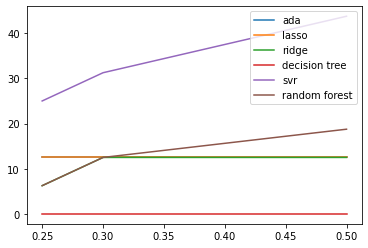

In [113]:
import matplotlib.pyplot as plt
import numpy as np

x = [.25, .3, .5]
plt.plot(x, [12.5, 12.5, 12.5])
plt.plot(x, [12.5, 12.5, 12.5])
plt.plot(x, [6.25, 12.5, 12.5])
plt.plot(x, [0.0, 0.0, 0.0])
plt.plot(x, [25.0, 31.25, 43.75])
plt.plot(x, [6.25, 12.5, 18.75])

plt.legend(['ada','lasso', 'ridge', 'decision tree', 'svr', 'random forest'], loc='upper right')

plt.show()